## Library Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Importing Baltimore calls for service dataset with call given highest priority and dataset description

In [2]:
data = pd.read_csv('911_Police_Calls_for_Service.csv')
data.head()

,RecordID,CallNumber,CallDateTime,Priority,District,Description,IncidentLocation,ZipCode,Neighborhood,PoliceDistrict,PolicePost,CouncilDistrict,SheriffDistricts,Community_Statistical_Areas,Census_Tracts,VRIZones,Location
0,620,P190530647,02/22/2019 05:05:00 AM,High,CD,COMMON ASSAULT,LIGHT ST/E LOMBARD ST,21202.0,Downtown West,Central,113.0,11.0,D7,Downtown/Seton Hill,Census Tract 401,NaN,"E LIGHT ST\nBALTIMORE, MD"
1,3408,P190521722,02/21/2019 01:15:00 PM,High,SE,OVERDOSE,0 N FRONT ST,21202.0,Jonestown,Southeastern,211.0,12.0,D7,Harbor East/Little Italy,Census Tract 302,NaN,"0 N FRONT ST\nBALTIMORE, MD"
2,6223,P190512183,02/20/2019 04:43:00 PM,High,WD,ARMED PERSON,W BALTIMORE ST/N MOUNT ST,21223.0,Franklin Square,Western,711.0,9.0,D8,Southwest Baltimore,Census Tract 1901,Tri-District,"W BALTIMORE ST\nST BALTIMORE, MD"
3,6305,P190512093,02/20/2019 04:12:00 PM,High,SD,AUTO ACC/INJURY,KEY HY/E MCCOMAS ST,21230.0,Locust Point Industrial Area,Southern,943.0,11.0,D7,South Baltimore,Census Tract 2404,NaN,"E KEY HY\nBALTIMORE, MD"
4,6841,P190511474,02/20/2019 12:06:00 PM,High,ND,ROBBERY ARMED,PARKWYRTH AV/OLD YORK RD,21218.0,Waverly,Northern,543.0,4.0,D2,Greater Govans,Census Tract 901,NaN,"PARKWYRTH AV\nBALTIMORE, MD"


In [3]:
data.describe()

,RecordID,ZipCode,PolicePost,CouncilDistrict
count,8.894200e+04,68123.000000,88877.000000,88886.000000
mean,5.716984e+06,21216.927352,520.903361,8.312119
std,2.253743e+06,10.211230,264.702261,3.717028
min,1.500000e+01,21201.000000,111.000000,1.000000
25%,6.121446e+06,21212.000000,312.000000,6.000000
50%,6.476531e+06,21217.000000,514.000000,9.000000
75%,6.826248e+06,21224.000000,742.000000,11.000000
max,7.463676e+06,21287.000000,943.000000,14.000000


In [4]:
columns_in_use = ['CallDateTime', 'PoliceDistrict']
columns_in_use

['CallDateTime', 'PoliceDistrict']

In [5]:
data = data[columns_in_use]
data.head()

,CallDateTime,PoliceDistrict
0,02/22/2019 05:05:00 AM,Central
1,02/21/2019 01:15:00 PM,Southeastern
2,02/20/2019 04:43:00 PM,Western
3,02/20/2019 04:12:00 PM,Southern
4,02/20/2019 12:06:00 PM,Northern


In [6]:
data.describe()

,CallDateTime,PoliceDistrict
count,88942,88876
unique,77097,9
top,03/19/2019 10:12:00 PM,Northeastern
freq,8,11963


## Data Cleaning

### Droping rows with null values

In [7]:
columns = data.columns.tolist()

null_count = 0

for i in columns:
    rows_with_null_values = data[data[i].isnull()].index
    print ('Number of Rows with null values in Column %s = %s'%(i, len(rows_with_null_values)))
    data = data.drop(rows_with_null_values, axis = 0)
    null_count += len(rows_with_null_values)

print ('Number of rows droped = ', null_count)
print ('Number of rows after droping null values = ', data.shape[0])
print ('Data Frame Shape: \n\t Number of Rows = %s \n\t Number of Columns = %s '%(data.shape[0], data.shape[1]))

Number of Rows with null values in Column CallDateTime = 0
Number of Rows with null values in Column PoliceDistrict = 66
Number of rows droped =  66
Number of rows after droping null values =  88876
Data Frame Shape: 
	 Number of Rows = 88876 
	 Number of Columns = 2 


### Converting CallDateTime columns from string to pandas date time

In [8]:
data['CallDateTime']  = pd.to_datetime(data['CallDateTime'])
data.head()

,CallDateTime,PoliceDistrict
0,2019-02-22 05:05:00,Central
1,2019-02-21 13:15:00,Southeastern
2,2019-02-20 16:43:00,Western
3,2019-02-20 16:12:00,Southern
4,2019-02-20 12:06:00,Northern


### Creating Day of week, week number, month and year column from CallDateTime column

In [9]:
day_of_week = data['CallDateTime'].dt.dayofweek
week = data['CallDateTime'].dt.week
month = data['CallDateTime'].dt.month
year = data['CallDateTime'].dt.year

data['Day'] = day_of_week
data['Week'] = week
data['Month'] = month
data['Year'] = year

In [10]:
data.describe()

,Day,Week,Month,Year
count,88876.000000,88876.000000,88876.000000,88876.0
mean,3.022560,26.048945,6.409256,2019.0
std,1.993039,14.353009,3.289828,0.0
min,0.000000,1.000000,1.000000,2019.0
25%,1.000000,14.000000,4.000000,2019.0
50%,3.000000,26.000000,6.000000,2019.0
75%,5.000000,38.000000,9.000000,2019.0
max,6.000000,52.000000,12.000000,2019.0


## Function to create a time series dataset, where police districts, week number and number of crime in that week are returned in a pandas dataframe

In [11]:
def ts_data_creation(group_by_parameter, data):
    parameters = {'Year':'Month', 'Month':'Week', 'Week':'Day', 'Day':'Error'}
    lower_group_by_parameter = parameters[group_by_parameter]
    
    if lower_group_by_parameter == 'Error':
        raise AttributeError('group_by_parameter cannot be "Day"')
        
    PoliceDistricts = set(data['PoliceDistrict'])
    ts_data = []
    for district in PoliceDistricts:
        for week_num, week_value in data[data['PoliceDistrict'] == district].groupby(group_by_parameter):
            total_weekly_cirmes = len(week_value)
            daily_crimes = [0] * 7
            for day_num, day_value in week_value.groupby(lower_group_by_parameter):
                total_daily_crime = len(day_value)
                daily_crimes[day_num] = total_daily_crime
            ts_data.append([district, week_num] + daily_crimes + [total_weekly_cirmes])
    ts_data = pd.DataFrame(ts_data, columns = ['PoliceDistrict', 'Week_Number', 'Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'NoOfCrimes'])
    return ts_data

### Timeseries dataframe

Dataframe shows total number of crimes, crimees per day in different police district in a given week of an year.

In [12]:
ts_data_week = ts_data_creation('Week', data)
ts_data_week.head()

,PoliceDistrict,Week_Number,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,NoOfCrimes
0,Central,1,29,69,56,32,32,28,30,276
1,Central,2,19,23,38,21,34,19,18,172
2,Central,3,19,28,20,38,29,34,27,195
3,Central,4,31,24,31,24,25,25,25,185
4,Central,5,33,39,23,22,44,33,26,220


### Crimes per week in different police district visualization 

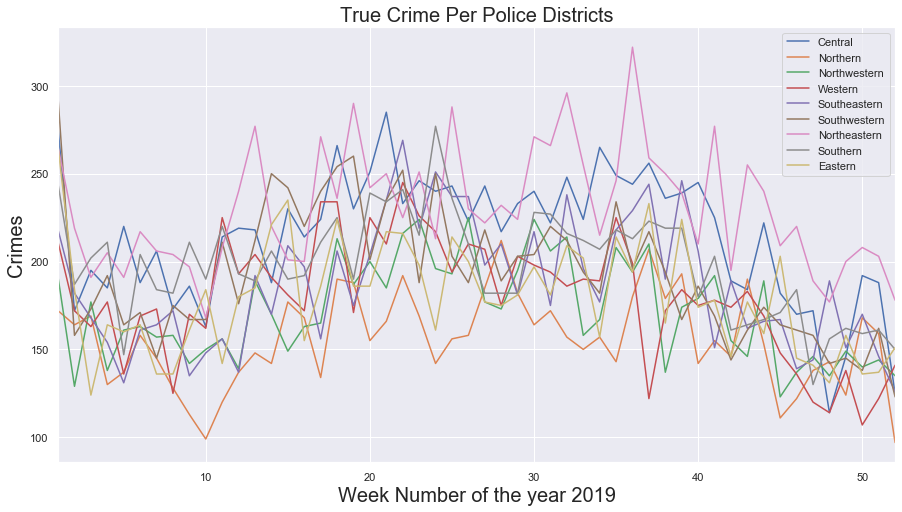

In [13]:
districts = set(ts_data_week['PoliceDistrict'])
df = pd.DataFrame()

for i in districts:
    values = ts_data_week[ts_data_week['PoliceDistrict'] == i]['NoOfCrimes'].tolist()
    index = ts_data_week[ts_data_week['PoliceDistrict'] == i]['Week_Number'].tolist()
    temp_df = pd.DataFrame(values, columns = [i], index = index)
    df = pd.concat([df, temp_df], axis = 1)
    

df.plot(figsize=(15,8))
plt.xlabel('Week Number of the year 2019', fontsize=20)
plt.ylabel('Crimes', fontsize=20)
plt.title('True Crime Per Police Districts', fontsize=20)
plt.savefig('policeDistrictCrimes.jpg')
plt.show()

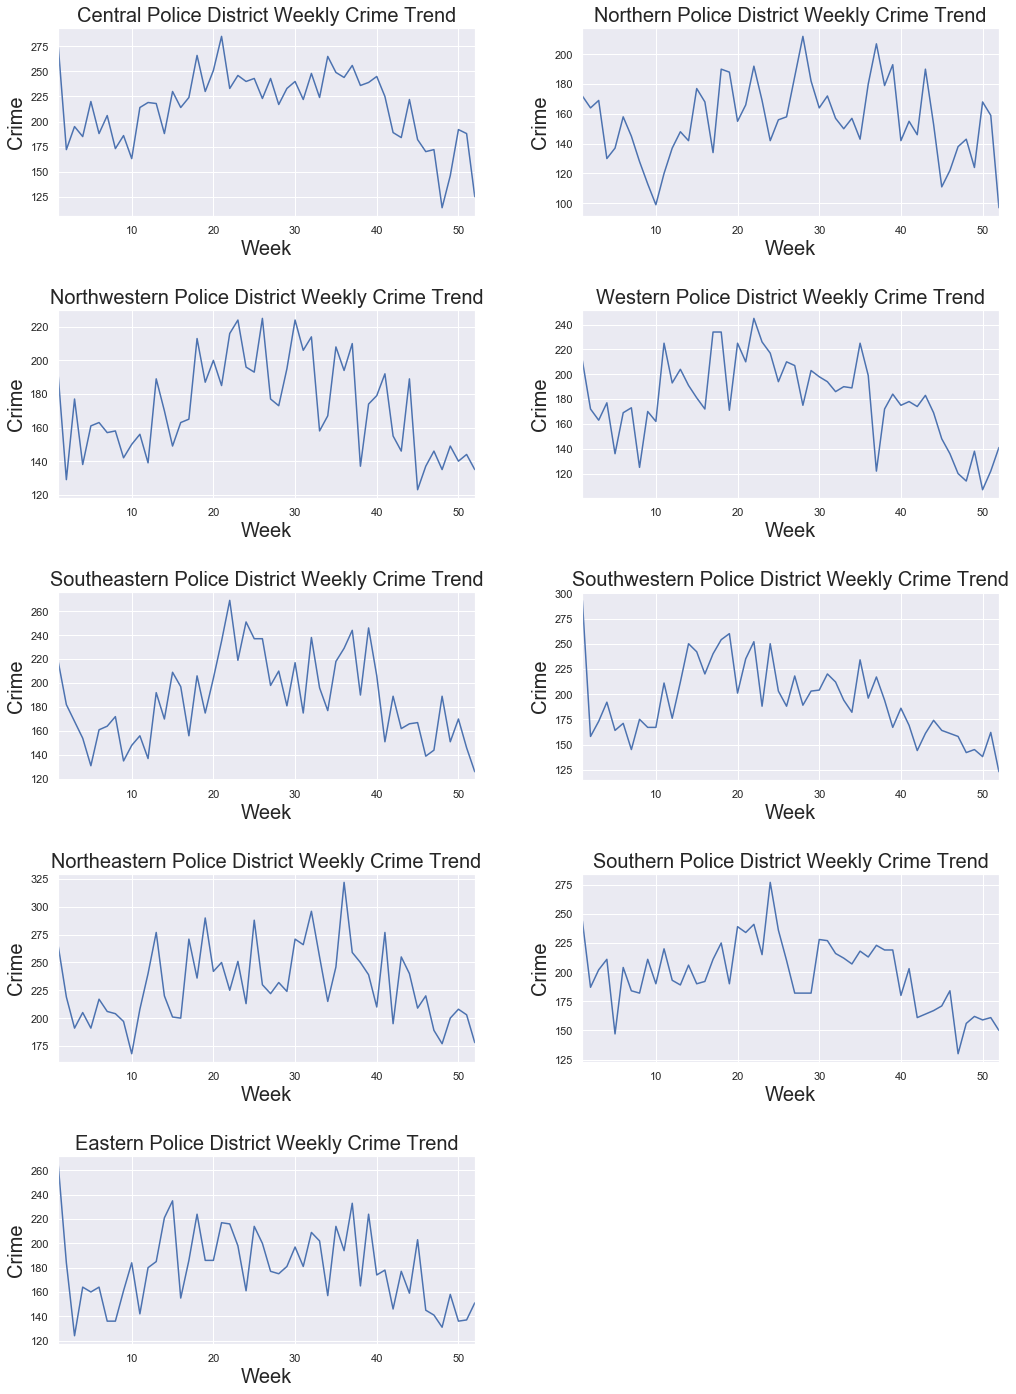

In [14]:
fig = plt.figure()
dist = list(districts)
i = 0

for pd_col in df:
    ax = '52%s'%(i+1)
    axis = fig.add_subplot(int(ax))
    df[pd_col].plot(ax = axis, figsize = (15,20))
    plt.xlabel('Week', fontsize = 20)
    plt.ylabel('Crime', fontsize = 20)
    title = '%s Police District Weekly Crime Trend' % dist[i]
    plt.title(title, fontsize = 20)
    i += 1
    
fig.tight_layout(pad=3.0) 
plt.savefig('True_Crime_Baltimre.jpg')

## Time Series Feature Extraction 

### Library Dependencies for making forecasting frame and Extracting time series features from it.

In [15]:
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_features

### Takes one police district at a time and creates forecating frame and its output (total cirme) for that district and append it to a list called temp_df. 

In [16]:
districts = set(ts_data_week['PoliceDistrict'])
df_shift = pd.DataFrame()
temp_df = []
for district in districts:
    temp_shift, temp_y = make_forecasting_frame(ts_data_week[ts_data_week['PoliceDistrict'] == district]['NoOfCrimes'], kind="crimes", max_timeshift=20, rolling_direction=1) 
    temp_df.append([temp_shift, temp_y])

### Create Time sereies features from make forecasting frames using tsfresh

In [17]:
ts_features = []

for i in temp_df:
    X = extract_features(i[0], column_id="id", column_sort="time", column_value="value", 
                             impute_function=impute, show_warnings=False)
    ts_features.append([X, i[1]])

Feature Extraction: 100%|██████████| 17/17 [00:00<00:00, 24.28it/s]


### Removing constant features

In [18]:
for i in ts_features:
    print (i[0].shape)
    i[0] = i[0].loc[:, i[0].apply(pd.Series.nunique) != 1] 
    print (i[0].shape)

(51, 754)
(51, 346)
(51, 754)
(51, 346)
(51, 754)
(51, 346)
(51, 754)
(51, 348)
(51, 754)
(51, 345)
(51, 754)
(51, 347)
(51, 754)
(51, 343)
(51, 754)
(51, 347)
(51, 754)
(51, 347)


### Adding a lag of 1 into the extraced time series feature dataframe

In [19]:
for i in ts_features:
    i[0]["feature_last_value"] = i[1].shift(1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Droping the first row becuase of null value created due ot lag

In [20]:
for i in ts_features:
    i[0] = i[0].iloc[1:, ]
    i[1] = i[1].iloc[1: ]

## Training and Tesing the models
### Libray dependencies for different models and their evaluation metrics

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import sklearn.utils
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor

import tqdm

### Expanding Window Forecast - 
An expanding window refers to a model that train on all available historic data and uses that to make a forecast.

It is an expanding window because it grows as more real observations are collected.

#### Traing random forest regressor using expanding window forecast approach and random forest regressor performance

In [22]:
y_pred = [[np.NaN] * len(ts_features[0][1]) for i in range(len(ts_features))]

isp = 10   # index of where to start the predictions
assert isp > 0

index = 0
for i in ts_features:
    RFR = RandomForestRegressor()
    for j in tqdm.tqdm(range(isp, len(i[1]))):
        RFR.fit(i[0].iloc[:j], i[1][:j])
        y_pred[index][j] = RFR.predict(i[0].iloc[j, :].values.reshape((1, -1)))[0]
    index += 1

#### Evaluation of random forest regressor prediction with actual value
    
y = []
prediction = {}
for i in range(len(temp_df)):
    y_true = np.array(temp_df[i][1].tolist())
    y_predicted = np.array(y_pred[i])
    temp = pd.DataFrame([y_true, y_predicted], index = ['True', 'Pred']).T 
    y.append(temp)
    
    dist = list(districts)[i]
    temp_pred = [np.nan] + y_pred[i]
    MSE = mean_squared_error(y_true[11:], temp_pred[11:])
    MAE = mean_absolute_error(y_true[11:], temp_pred[11:])
    prediction[dist] = {'MSE': MSE, 'MAE': MAE}
    print ('Mean Squared Error for district %s = %s'%(dist, MSE))
    print ('Mean Absolute Error for district %s = %s\n\n'%(dist, MAE))

#### Finding average of MSE and MAE

total_MSE = 0
total_MAE = 0
for i in prediction:
    total_MSE += prediction[i]['MSE']
    total_MAE += prediction[i]['MAE']
    
avg_MSE = total_MSE/len(districts)
avg_MAE = total_MAE/len(districts)

print ('Average of Mean Squared Error = %s'%avg_MSE)
print ('Average of Mean Absolute Error = %s'%avg_MAE)

100%|██████████| 40/40 [00:07<00:00,  5.49it/s]

Mean Squared Error for district Central = 936.8607250000001
Mean Absolute Error for district Central = 21.883499999999998


Mean Squared Error for district Northern = 680.5227725
Mean Absolute Error for district Northern = 20.86225


Mean Squared Error for district Northwestern = 634.5304949999999
Mean Absolute Error for district Northwestern = 20.740999999999996


Mean Squared Error for district Western = 719.840625
Mean Absolute Error for district Western = 19.107999999999997


Mean Squared Error for district Southeastern = 1068.08547
Mean Absolute Error for district Southeastern = 27.008500000000005


Mean Squared Error for district Southwestern = 722.8628999999999
Mean Absolute Error for district Southwestern = 23.320500000000003


Mean Squared Error for district Northeastern = 1128.4462274999998
Mean Absolute Error for district Northeastern = 27.773249999999997


Mean Squared Error for district Southern = 658.31213
Mean Absolute Error for district Southern = 20.3205


Mean Squared

#### Random Forest regressor prediction visualization 

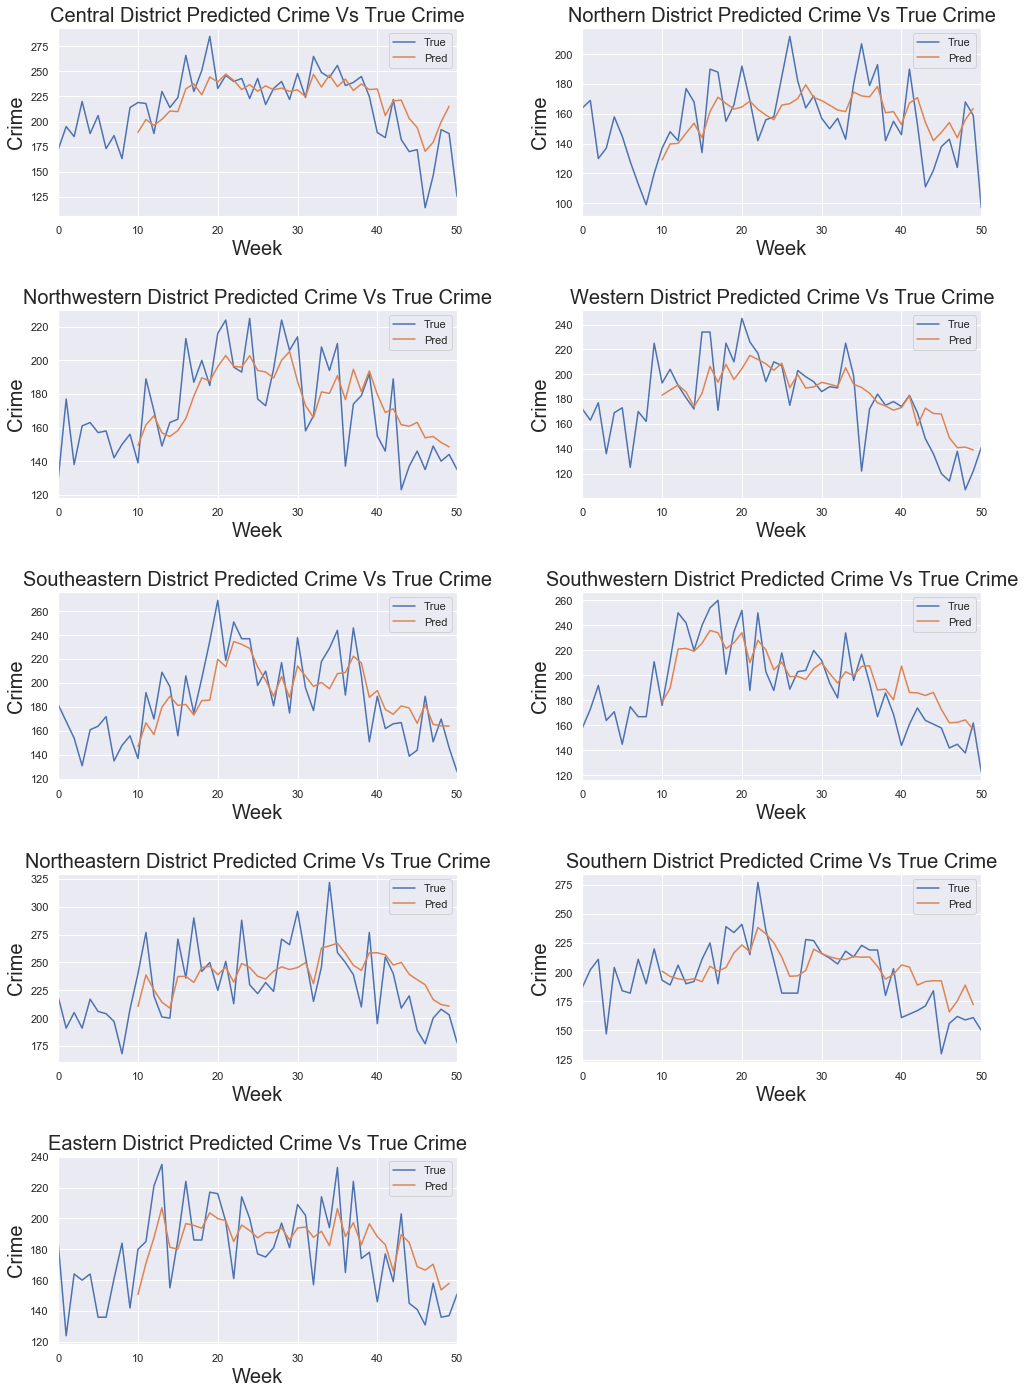

In [23]:
fig = plt.figure()
dist = list(districts)

for i in range(0, 9):
    ax = '52%s'%(i+1)
    axis = fig.add_subplot(int(ax))
    y[i].plot(ax = axis, figsize = (15,20))
    plt.xlabel('Week', fontsize = 20)
    plt.ylabel('Crime', fontsize = 20)
    title = '%s District Predicted Crime Vs True Crime' % dist[i]
    plt.title(title, fontsize = 20)
    
fig.tight_layout(pad=3.0) 
plt.savefig('Predicted_Crime_Vs_True_Crime_RFR.jpg')

#### Traing Multilayer Perceptron regressor using expanding window forecast approach and random forest regressor performance

In [24]:
y_pred = [[np.NaN] * len(ts_features[0][1]) for i in range(len(ts_features))]

isp = 10   # index of where to start the predictions
assert isp > 0

index = 0
for i in ts_features:
    MLPR = MLPRegressor()
    for j in tqdm.tqdm(range(isp, len(i[1]))):
        MLPR.fit(i[0].iloc[:j], i[1][:j])
        y_pred[index][j] = MLPR.predict(i[0].iloc[j, :].values.reshape((1, -1)))[0]
    index += 1

#### Evaluation of multilayer perceptron regressor prediction with actual value
    
y = []
prediction = {}
for i in range(len(temp_df)):
    y_true = np.array(temp_df[i][1].tolist())
    y_predicted = np.array(y_pred[i])
    temp = pd.DataFrame([y_true, y_predicted], index = ['True', 'Pred']).T 
    y.append(temp)
    
    dist = list(districts)[i]
    temp_pred = [np.nan] + y_pred[i]
    MSE = mean_squared_error(y_true[11:], temp_pred[11:])
    MAE = mean_absolute_error(y_true[11:], temp_pred[11:])
    prediction[dist] = {'MSE': MSE, 'MAE': MAE}
    print ('Mean Squared Error for district %s = %s'%(dist, MSE))
    print ('Mean Absolute Error for district %s = %s\n\n'%(dist, MAE))

#### Finding average of MSE and MAE

total_MSE = 0
total_MAE = 0
for i in prediction:
    total_MSE += prediction[i]['MSE']
    total_MAE += prediction[i]['MAE']
    
avg_MSE = total_MSE/len(districts)
avg_MAE = total_MAE/len(districts)

print ('Average of Mean Squared Error = %s'%avg_MSE)
print ('Average of Mean Absolute Error = %s'%avg_MAE)

  0%|          | 0/40 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 10%|█         | 4/40 [00:00<00:02, 17.48it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 15%|█▌        | 6/40 [00:00<00:02, 15.27it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 18%|█▊        | 7/40 [00:00<00:02, 11.15it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_netw

  0%|          | 0/40 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
  2%|▎         | 1/40 [00:00<00:05,  6.69it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 12%|█▎        | 5/40 [00:00<00:04,  7.89it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 15%|█▌        | 6/40 [00:00<00:04,  7.38it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_netw

 70%|███████   | 28/40 [00:02<00:01, 10.84it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 75%|███████▌  | 30/40 [00:02<00:01,  8.70it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 80%|████████  | 32/40 [00:02<00:00,  9.24it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: 

 50%|█████     | 20/40 [00:01<00:01, 11.52it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 57%|█████▊    | 23/40 [00:01<00:01, 12.55it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 62%|██████▎   | 25/40 [00:02<00:01, 12.16it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 70%|███████   | 28/40 [00:02<00:00, 12.66it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn

 48%|████▊     | 19/40 [00:01<00:02,  9.49it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 52%|█████▎    | 21/40 [00:01<00:01,  9.83it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 57%|█████▊    | 23/40 [00:02<00:02,  8.43it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: 

Mean Squared Error for district Central = 76330887267.13402
Mean Absolute Error for district Central = 144596.56742623184


Mean Squared Error for district Northern = 4253535466.996769
Mean Absolute Error for district Northern = 34110.105523534825


Mean Squared Error for district Northwestern = 6777325081.584684
Mean Absolute Error for district Northwestern = 41680.285602449316


Mean Squared Error for district Western = 12371551375.133352
Mean Absolute Error for district Western = 58647.52559095372


Mean Squared Error for district Southeastern = 10425216006.837606
Mean Absolute Error for district Southeastern = 55158.29930194611


Mean Squared Error for district Southwestern = 12878785519.13828
Mean Absolute Error for district Southwestern = 60337.42672565389


Mean Squared Error for district Northeastern = 43641474793.484116
Mean Absolute Error for district Northeastern = 127746.90757342735


Mean Squared Error for district Southern = 19552381558.560593
Mean Absolute Error for dist

#### MLPR prediction visualization

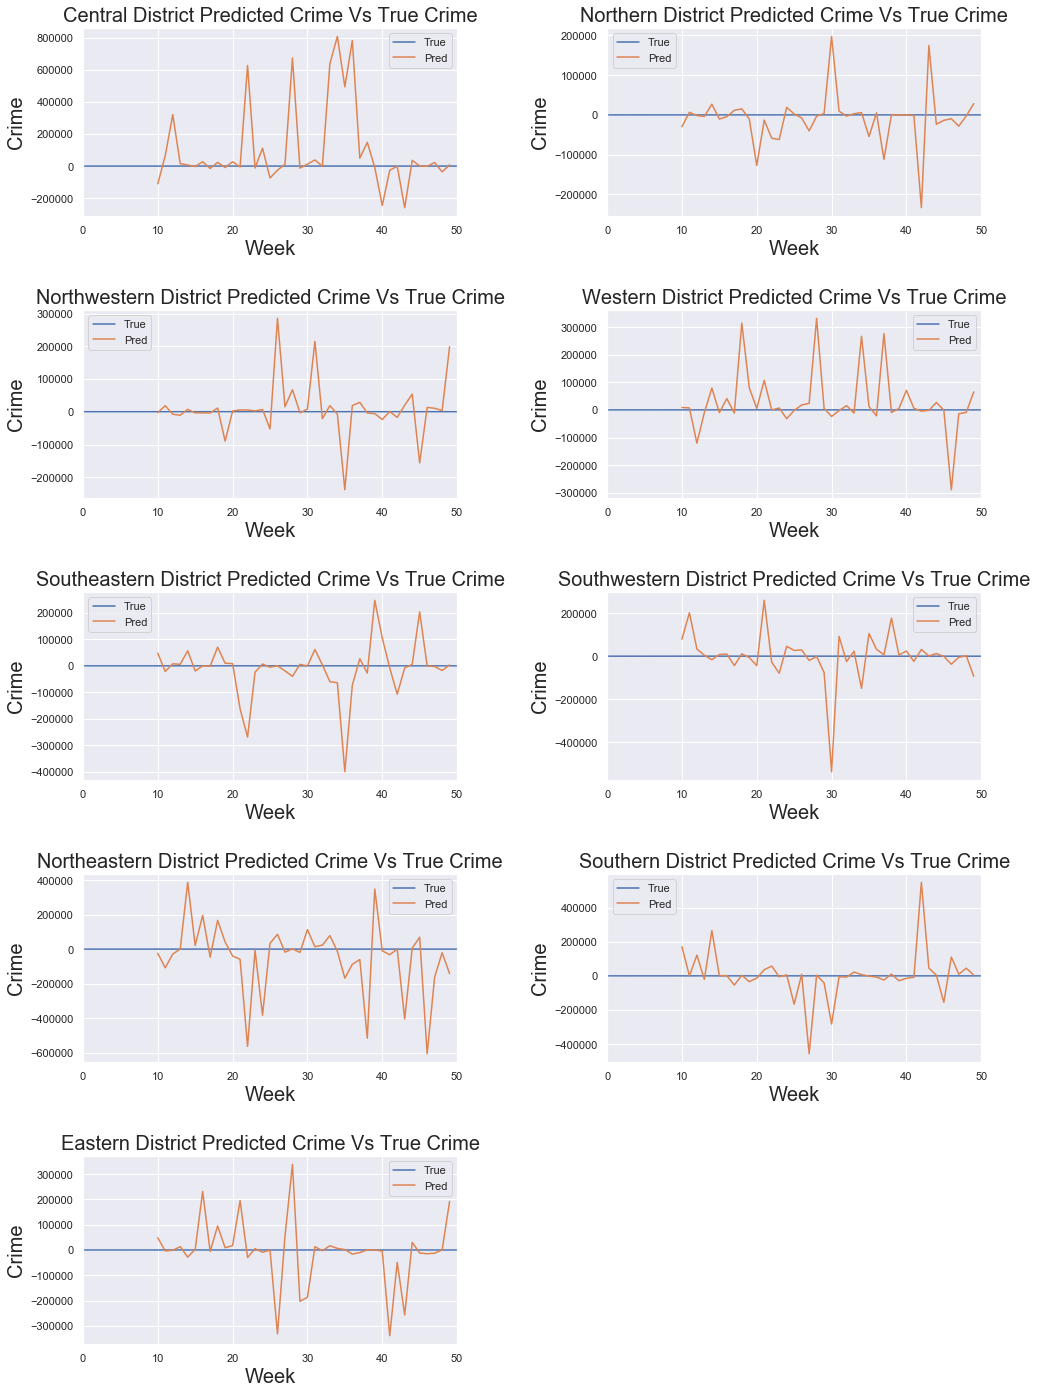

In [25]:
fig = plt.figure()
dist = list(districts)

for i in range(0, 9):
    ax = '52%s'%(i+1)
    axis = fig.add_subplot(int(ax))
    y[i].plot(ax = axis, figsize = (15,20))
    plt.xlabel('Week', fontsize = 20)
    plt.ylabel('Crime', fontsize = 20)
    title = '%s District Predicted Crime Vs True Crime' % dist[i]
    plt.title(title, fontsize = 20)
    
fig.tight_layout(pad=3.0) 
plt.savefig('Predicted_Crime_Vs_True_Crime_MLPRegressor.jpg')

#### Traing support vector regressor using expanding window forecast approach and random forest regressor performance

In [26]:
y_pred = [[np.NaN] * len(ts_features[0][1]) for i in range(len(ts_features))]

isp = 10   # index of where to start the predictions
assert isp > 0

index = 0
for i in ts_features:
    SVRegr = SVR()
    for j in tqdm.tqdm(range(isp, len(i[1]))):
        SVRegr.fit(i[0].iloc[:j], i[1][:j])
        y_pred[index][j] = SVRegr.predict(i[0].iloc[j, :].values.reshape((1, -1)))[0]
    index += 1

#### Evaluation of support vector regressor prediction with actual value
    
y = []
prediction = {}
for i in range(len(temp_df)):
    y_true = np.array(temp_df[i][1].tolist())
    y_predicted = np.array(y_pred[i])
    temp = pd.DataFrame([y_true, y_predicted], index = ['True', 'Pred']).T 
    y.append(temp)
    
    dist = list(districts)[i]
    temp_pred = [np.nan] + y_pred[i]
    MSE = mean_squared_error(y_true[11:], temp_pred[11:])
    MAE = mean_absolute_error(y_true[11:], temp_pred[11:])
    prediction[dist] = {'MSE': MSE, 'MAE': MAE}
    print ('Mean Squared Error for district %s = %s'%(dist, MSE))
    print ('Mean Absolute Error for district %s = %s\n\n'%(dist, MAE))
    
#### Finding average of MSE and MAE
    
total_MSE = 0
total_MAE = 0
for i in prediction:
    total_MSE += prediction[i]['MSE']
    total_MAE += prediction[i]['MAE']
    
avg_MSE = total_MSE/len(districts)
avg_MAE = total_MAE/len(districts)

print ('Average of Mean Squared Error = %s'%avg_MSE)
print ('Average of Mean Absolute Error = %s'%avg_MAE)

100%|██████████| 40/40 [00:00<00:00, 496.31it/s]

Mean Squared Error for district Central = 1543.9425091925248
Mean Absolute Error for district Central = 30.422715684410075


Mean Squared Error for district Northern = 786.6078820754083
Mean Absolute Error for district Northern = 22.533179255788564


Mean Squared Error for district Northwestern = 1030.636649200936
Mean Absolute Error for district Northwestern = 27.81428091239883


Mean Squared Error for district Western = 1328.682380770474
Mean Absolute Error for district Western = 28.597860769492968


Mean Squared Error for district Southeastern = 1713.9893324729921
Mean Absolute Error for district Southeastern = 35.27948699848812


Mean Squared Error for district Southwestern = 1541.4045176876284
Mean Absolute Error for district Southwestern = 32.688891030835286


Mean Squared Error for district Northeastern = 1573.6935122754307
Mean Absolute Error for district Northeastern = 31.782535521362966


Mean Squared Error for district Southern = 1063.8944056037328
Mean Absolute Error for di

#### SVR visualization

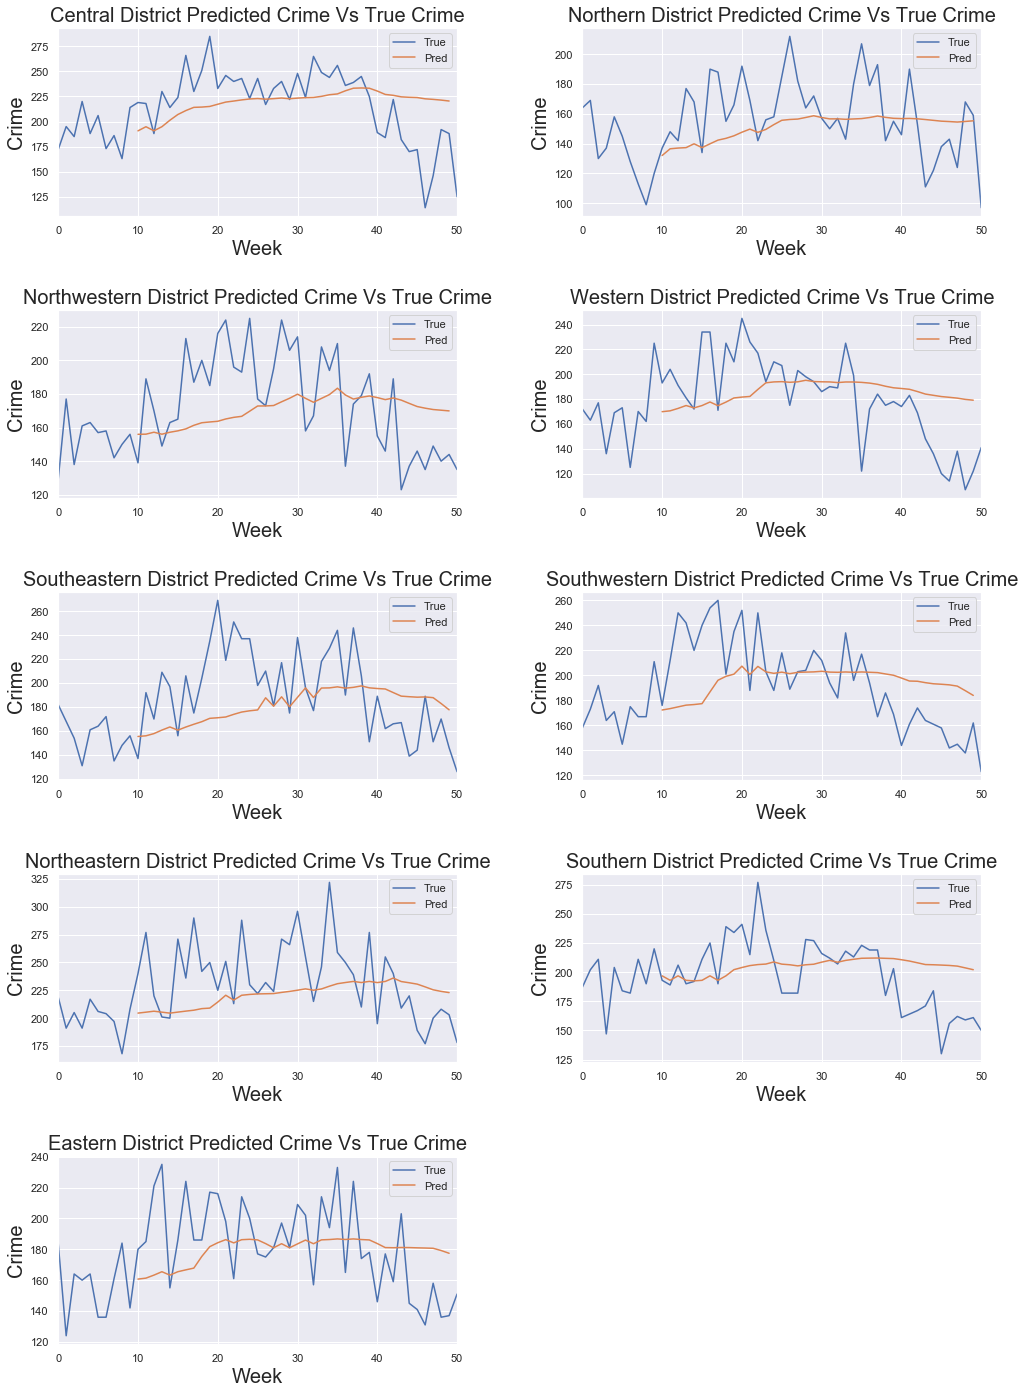

In [27]:
fig = plt.figure()
dist = list(districts)

for i in range(0, 9):
    ax = '52%s'%(i+1)
    axis = fig.add_subplot(int(ax))
    y[i].plot(ax = axis, figsize = (15,20))
    plt.xlabel('Week', fontsize = 20)
    plt.ylabel('Crime', fontsize = 20)
    title = '%s District Predicted Crime Vs True Crime' % dist[i]
    plt.title(title, fontsize = 20)
    
fig.tight_layout(pad=3.0) 
plt.savefig('Predicted_Crime_Vs_True_Crime_SVR.jpg')

## Recursive Feature Elimination From Random Forest Regressor

Since Random Forest Regressor Outperforms other model we will use it for eliminating features recursively. 

### Library Dependencies for Recursive Feature Elimination

In [28]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

In [29]:
district_imp_features = {}
district_list = list(districts) 
j = 0
for i in ts_features:
    model = RandomForestRegressor()
    model = RFE(model, 10)
    model = model.fit(i[0], i[1])
    imp_columns = i[0].columns[model.support_ == True]
    district = district_list[j]
    district_imp_features[district] = imp_columns
    j += 1
    
district_imp_features = pd.DataFrame(district_imp_features)
district_imp_features

,Central,Northern,Northwestern,Western,Southeastern,Southwestern,Northeastern,Southern,Eastern
0,"value__agg_linear_trend__f_agg_""mean""__chunk_l...","value__agg_linear_trend__f_agg_""max""__chunk_le...","value__change_quantiles__f_agg_""mean""__isabs_F...","value__change_quantiles__f_agg_""mean""__isabs_F...","value__agg_linear_trend__f_agg_""var""__chunk_le...","value__change_quantiles__f_agg_""mean""__isabs_T...","value__agg_autocorrelation__f_agg_""mean""__maxl...",value__absolute_sum_of_changes,value__autocorrelation__lag_3
1,"value__agg_linear_trend__f_agg_""var""__chunk_le...","value__agg_linear_trend__f_agg_""min""__chunk_le...","value__change_quantiles__f_agg_""var""__isabs_Fa...","value__change_quantiles__f_agg_""mean""__isabs_T...","value__augmented_dickey_fuller__autolag_""AIC""_...","value__change_quantiles__f_agg_""var""__isabs_Fa...",value__autocorrelation__lag_6,"value__agg_linear_trend__f_agg_""min""__chunk_le...","value__change_quantiles__f_agg_""mean""__isabs_F..."
2,"value__change_quantiles__f_agg_""var""__isabs_Tr...","value__cwt_coefficients__widths_(2, 5, 10, 20)...","value__cwt_coefficients__widths_(2, 5, 10, 20)...","value__change_quantiles__f_agg_""var""__isabs_Fa...","value__change_quantiles__f_agg_""mean""__isabs_F...","value__change_quantiles__f_agg_""var""__isabs_Fa...","value__cwt_coefficients__widths_(2, 5, 10, 20)...",value__approximate_entropy__m_2__r_0.3,"value__fft_coefficient__coeff_6__attr_""real"""
3,"value__cwt_coefficients__widths_(2, 5, 10, 20)...","value__cwt_coefficients__widths_(2, 5, 10, 20)...","value__cwt_coefficients__widths_(2, 5, 10, 20)...","value__change_quantiles__f_agg_""var""__isabs_Fa...","value__cwt_coefficients__widths_(2, 5, 10, 20)...","value__change_quantiles__f_agg_""var""__isabs_Tr...",value__energy_ratio_by_chunks__num_segments_10...,"value__change_quantiles__f_agg_""mean""__isabs_F...","value__fft_coefficient__coeff_7__attr_""real"""
4,"value__fft_coefficient__coeff_6__attr_""real""",value__energy_ratio_by_chunks__num_segments_10...,value__energy_ratio_by_chunks__num_segments_10...,value__cid_ce__normalize_False,value__energy_ratio_by_chunks__num_segments_10...,"value__change_quantiles__f_agg_""var""__isabs_Tr...","value__fft_coefficient__coeff_1__attr_""angle""","value__change_quantiles__f_agg_""mean""__isabs_T...","value__fft_coefficient__coeff_8__attr_""angle"""
5,value__kurtosis,"value__fft_coefficient__coeff_3__attr_""angle""","value__fft_coefficient__coeff_9__attr_""real""","value__cwt_coefficients__widths_(2, 5, 10, 20)...","value__fft_coefficient__coeff_3__attr_""angle""","value__cwt_coefficients__widths_(2, 5, 10, 20)...","value__fft_coefficient__coeff_7__attr_""angle""","value__change_quantiles__f_agg_""var""__isabs_Tr...",value__last_location_of_minimum
6,"value__linear_trend__attr_""rvalue""","value__fft_coefficient__coeff_7__attr_""imag""",value__first_location_of_maximum,"value__cwt_coefficients__widths_(2, 5, 10, 20)...","value__fft_coefficient__coeff_3__attr_""imag""","value__fft_coefficient__coeff_6__attr_""abs""","value__linear_trend__attr_""rvalue""",value__cid_ce__normalize_False,"value__linear_trend__attr_""rvalue"""
7,"value__linear_trend__attr_""slope""","value__fft_coefficient__coeff_8__attr_""abs""","value__linear_trend__attr_""rvalue""",value__energy_ratio_by_chunks__num_segments_10...,value__first_location_of_minimum,"value__fft_coefficient__coeff_8__attr_""imag""",value__partial_autocorrelation__lag_5,"value__fft_coefficient__coeff_2__attr_""abs""",value__number_cwt_peaks__n_5
8,value__percentage_of_reoccurring_datapoints_to...,value__first_location_of_minimum,"value__linear_trend__attr_""slope""","value__linear_trend__attr_""rvalue""",value__last_location_of_minimum,"value__linear_trend__attr_""rvalue""",value__time_reversal_asymmetry_statistic__lag_2,"value__fft_coefficient__coeff_8__attr_""abs""",value__partial_autocorrelation__lag_5
9,value__time_reversal_asymmetry_statistic__lag_2,value__last_location_of_maximum,value__mean_chan